In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

warnings.filterwarnings('ignore')

# Introduction to Pulsar Timing

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/matteobachetti/timing-lectures)

<img src="0737.png" alt="0737" style="height: 300px;margin: auto;"/>

(These slides are obtained from the iPython notebook that can be found [here](https://github.com/matteobachetti/timing-lectures))

## Contents

* Finding pulsars: the buried clock

* Frequency analysis: the Fourier Transform and the Power Density Spectrum

* Refine the search: Folding search (+ $Z^2_n$, $H$-test, ...)

* Getting pulse arrival times 

# Finding pulsars: the buried clock

<img src="buriedclock.jpg" alt="Buried Clock" style="height: 300px;margin: auto;"/>



# Finding pulsars: the buried clock

* Pulsars are stable rotators: very predictable "clocks"

<img src="smallmodpulsar.gif" alt="Pulsar" style="height: 300px;margin: auto;"/>

# Finding pulsars: the buried clock

* Pulsars are stable rotators: very predictable "clocks"

* Often signal buried in noise (below: a 0.853-Hz sinusoidal pulse buried in noise ~30 times stronger)

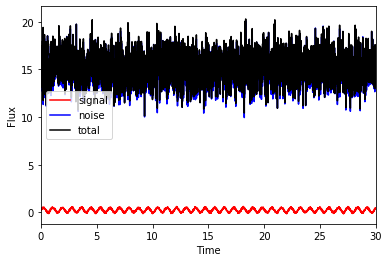

In [2]:
def pulsar(time, period=1):
    return (1 + np.sin(2 * np.pi / period * time)) / 2.

time_bin = 0.009

# --- Parameters ----
period = 0.8532
pulsar_amp = 0.5
pulsar_stdev = 0.05
noise_amp = 15
noise_stdev = 1.5
# --------------------

# refer to the center of the time bin
time = np.arange(0, 100, time_bin) + time_bin / 2

signal = np.random.normal(pulsar_amp * pulsar(time, period), pulsar_stdev)
noise = np.random.normal(noise_amp, noise_stdev, len(time))
total = signal + noise

# PLOTTING -------------------------
plt.plot(time, signal, 'r-', label='signal')
plt.plot(time, noise, 'b-', label='noise')
plt.plot(time, total, 'k-', label='total')
plt.xlim(0, 30)
plt.xlabel('Time')
plt.ylabel('Flux')
a = plt.legend()
# -----------------------------------

# Frequency analysis: the Fourier Transform

Through the Fourier transform, we can decompose a function of time into a series of functions of frequency:

\begin{equation}
\mathcal{F}(\omega) = \int^{\infty}_{-\infty} e^{-i\omega t} f(t)
\end{equation}

or, more appropriate to our case, in the discrete form, we can decompose a time series into a frequency series:

\begin{equation}
F_k = \sum^{N-1}_{k=0} e^{-2\pi i k n/N} t_n
\end{equation}

it is, in general, a **complex** function.

The Fourier transform of a sinusoid will give a high (in absolute terms) value of the $F_k$ corresponding to the frequency of the sinusoid. Other periodic functions will produce high contribution at the fundamental frequency plus one or more multiples of the fundamental, called *harmonics*.


## Our example

Let's take the Fourier transform of the signal we simulated above (only taking *positive* frequencies)

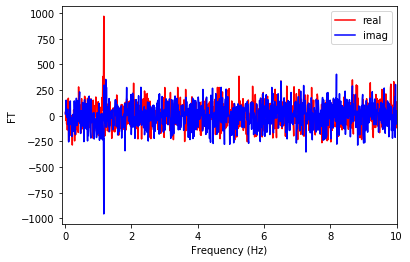

In [3]:
ft = np.fft.fft(total)
freqs = np.fft.fftfreq(len(total), time[1] - time[0])
good = freqs >0
freqs = freqs[good]
ft = ft[good]

# PLOTTING ---------------------------
plt.plot(freqs, ft.real, 'r-', label='real')
plt.plot(freqs, ft.imag, 'b-', label='imag')
plt.xlim([-0.1, 10])
a = plt.legend()
_ = plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('FT')
# -------------------------------------

Note that the imaginary part and real part of the Fourier transform have different contributions at the pulsar frequency (1/0.85 s ~ 1.2 Hz). This is because they depend strongly on the phase of the signal [Exercise: **why?**].

## Our example - 2

 If we applied a shift of 240 ms (just any value) to the signal:

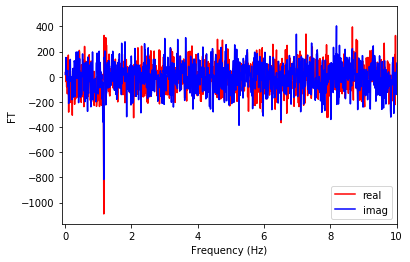

In [4]:
shift = 0.240
signal_shift = np.roll(total, int(shift / time_bin))
ft_shift = np.fft.fft(signal_shift)
freqs_shift = np.fft.fftfreq(len(total), time[1] - time[0])
good = freqs_shift >0
freqs_shift = freqs_shift[good]
ft_shift = ft_shift[good]

# PLOTTING -------------------------------------
plt.plot(freqs_shift, ft_shift.real, 'r-', label='real')
plt.plot(freqs_shift, ft_shift.imag, 'b-', label='imag')
plt.xlim([-0.1, 10])
a = plt.legend()
_ = plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('FT')
# ----------------------------------------------

we would clearly have non-zero values at ~0.85 Hz both in the real and the imaginary parts.

# The Power Density Spectrum

To solve these issues with real and imaginary parts, we can instead take the *modulus* of the Fourier transform. This is called **Power Spectrum**

\begin{equation}
\mathcal{P}(\omega) = \mathcal{F}(\omega) \cdot \mathcal{F}^*(\omega)
\end{equation}

this function is positive-definite and in our case results in a clear peak at the pulse frequency, *consistent* between original and shifted signal:

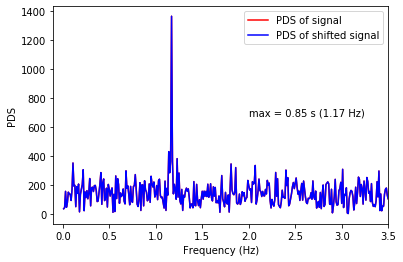

In [5]:
pds = np.abs(ft)
pds_shift = np.abs(ft_shift)

fmax = freqs[np.argmax(pds)]
pmax = 1 / fmax

# PLOTTING ---------------------------------
plt.plot(freqs, pds, 'r-', label='PDS of signal')
plt.plot(freqs_shift, pds_shift, 'b-', label='PDS of shifted signal')
a = plt.legend()
a = plt.xlabel('Frequency (Hz)')
a = plt.ylabel('PDS')
plt.xlim([-0.1, 3.5])
_ = plt.gca().annotate('max = {:.2f} s ({:.2f} Hz)'.format(pmax, fmax), xy=(2., max(pds) / 2))
# -------------------------------------------

## The Power Density Spectrum -2

The PDS of a generic non-sinusoidal pulse profile will, in general, contain more than one harmonic, with the fundamental not always predominant.

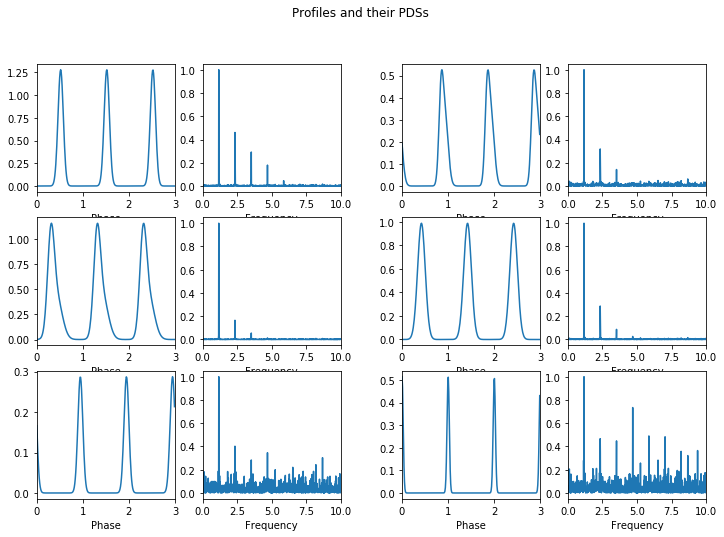

In [6]:
def gaussian_periodic(x, x0, amp, width):
    '''Approximates a Gaussian periodic function by summing the contributions in the phase
    range 0--1 with those in the phase range -1--0 and 1--2'''
    phase = x - np.floor(x)
    lc = np.zeros_like(x)
    for shift in [-1, 0, 1]:
        lc += amp * np.exp(-(phase + shift - x0)**2 / width ** 2)
        
    return lc

def generate_profile(time, period):
    '''Simulate a given profile with 1-3 Gaussian components'''
    total_phase = time / period
    ngauss = np.random.randint(1, 3)
    lc = np.zeros_like(total_phase)
    for i in range(ngauss):
        ph0 = np.random.uniform(0, 1)
        amp = np.random.uniform(0.1, 1)
        width = np.random.uniform(0.01, 0.2)
        lc += gaussian_periodic(total_phase, ph0, amp, width)
    
    return lc

# PLOTTING -------------------------
ncols = 2
nrows = 3
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Profiles and their PDSs')

gs = gridspec.GridSpec(nrows, ncols)

for c in range(ncols):
    for r in range(nrows):
# ----------------------------------

        lc = generate_profile(time, period)
        lc_noisy = np.random.normal(2 * lc, 0.2) + noise
        
        lcft = np.fft.fft(lc_noisy)
        lcfreq = np.fft.fftfreq(len(lc_noisy), time[1] - time[0])
        lcpds = np.absolute(lcft) ** 2 

        # PLOTTING -------------------------

        gs_2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[r, c])
        ax = plt.subplot(gs_2[0])
        good = time < period * 3
        ax.plot(time[good] / period, lc[good])
        
        ax.set_xlim([0,3])
        ax.set_xlabel('Phase')
        
        ax = plt.subplot(gs_2[1])
        ax.plot(lcfreq[lcfreq > 0], lcpds[lcfreq > 0] / max(lcpds[lcfreq > 0]))
        ax.set_xlabel('Frequency')
        ax.set_xlim([0, 10])

        # ----------------------------------

# Epoch folding

Epoch folding consists of summing equal, one pulse period-long, chunks of data. If the period is just right, the crests will sum up in phase, gaining signal over noise [Exercise: **how much will we gain** by summing up in phase $N$ chunks of data at the right period?].

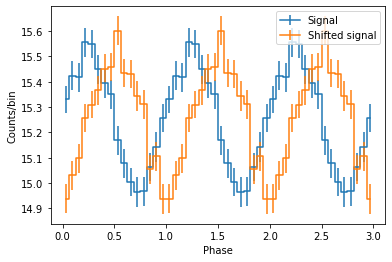

In [7]:
def epoch_folding(time, signal, period, nperiods=3, nbin=16):
    # The phase of the pulse is always between 0 and 1.
    phase = time / period
    phase -= phase.astype(int)
    
    # First histogram: divide phase range in nbin bins, and count how many signal bins
    # fall in each histogram bin. The sum is weighted by the value of the signal at 
    # each phase
    prof_raw, bins = np.histogram(
        phase, bins=np.linspace(0, 1, nbin + 1),
        weights=signal)
    # "Exposure": how many signal bins have been summed in each histogram bin
    expo, bins = np.histogram(phase, bins=np.linspace(0, 1, nbin + 1))
    
    # ---- Evaluate errors -------
    prof_sq, bins = np.histogram(
        phase, bins=np.linspace(0, 1, nbin + 1),
        weights=signal ** 2)
    # Variance of histogram bin: "Mean of squares minus square of mean" X N
    hist_var = (prof_sq / expo - (prof_raw / expo) ** 2) * expo
    # Then, take square root -> Stdev, then normalize / N. 
    prof_err = np.sqrt(hist_var)
    #-----------------------------
    # Normalize by exposure
    prof = prof_raw / expo
    prof_err = prof_err / expo
    
    # histogram returns all bin edges, including last one. Here we take the
    # center of each bin.
    phase_bins = (bins[1:] + bins[:-1]) / 2
    
    # ---- Return the same pattern 'nperiods' times, for visual purposes -----
    final_prof = np.array([])
    final_phase = np.array([])
    final_prof_err = np.array([])
    for n in range(nperiods):
        final_prof = np.append(final_prof, prof)
        final_phase = np.append(final_phase, phase_bins + n)
        final_prof_err = np.append(final_prof_err, prof_err)
    # ---------------------------
    return final_phase, final_prof, final_prof_err

phase, profile, profile_err = epoch_folding(time, total, period)
phase_shift, profile_shift, profile_shift_err = epoch_folding(time, signal_shift, period)

# PLOTTING -------------------------------------------------------------
plt.errorbar(
    phase, profile, yerr=profile_err, drawstyle='steps-mid',
    label='Signal')
plt.errorbar(
    phase_shift, profile_shift, yerr=profile_shift_err,
    drawstyle='steps-mid', label='Shifted signal')

_ = plt.legend()
_ = plt.xlabel('Phase')
_ = plt.ylabel('Counts/bin')
# -------------------------------------------------------------------

# Epoch folding search

Now, let's run epoch folding at a number of trial periods around the pulse period. To evaluate how much a given profile "looks pulsar-y", we can use the $\chi^2$ statistics, as follows:

\begin{equation}
\mathcal{S} = \sum_{i=0}^N \frac{(p_i - \bar{p})^2}{\sigma_p^2}
\end{equation}

for each profile obtained for each trial value of the pulse frequency and look for peaks$^1$. [Exercise: do you know what statistics this is? And why does that statistics work for our case? Exercise-2: Note the very large number of trials. Can we optimize the search so that we use less trials without losing sensitivity?]

$^1$ 1.	Leahy, D. A. et al. On searches for pulsed emission with application to four globular cluster X-ray sources - NGC 1851, 6441, 6624, and 6712. _ApJ_ **266**, 160 (1983).

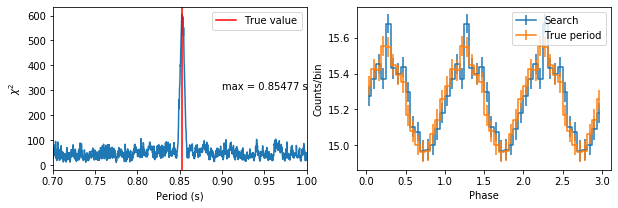

In [8]:
def pulse_profile_stat(profile, profile_err):
    return np.sum(
        (profile - np.mean(profile)) ** 2 / profile_err ** 2)

trial_periods = np.arange(0.7, 1.0, 0.0002)
stats = np.zeros_like(trial_periods)
for i, p in enumerate(trial_periods):
    phase, profile, profile_err = epoch_folding(time, total, p)
    stats[i] = pulse_profile_stat(profile, profile_err)

bestp = trial_periods[np.argmax(stats)]

phase_search, profile_search, profile_search_err = \
    epoch_folding(time, total, bestp)
phase, profile, profile_err = epoch_folding(time, total, period)

# PLOTTING -------------------------------
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.plot(trial_periods, stats)
ax.set_xlim([0.7, 1])
ax.set_xlabel('Period (s)')
ax.set_ylabel('$\chi^2$')
ax.axvline(period, color='r', label="True value")
_ = ax.legend()
ax.annotate('max = {:.5f} s'.format(pmax), xy=(.9, max(stats) / 2))

ax2 = plt.subplot(gs[1])

ax2.errorbar(phase_search, profile_search, yerr=profile_search_err,
             drawstyle='steps-mid', label='Search')
ax2.errorbar(phase, profile, yerr=profile_err, drawstyle='steps-mid',
             label='True period')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Counts/bin')

_ = ax2.legend()
# ------------------------------------------

# Times of arrival (TOA)
To calculate the time of arrival of the pulses, we need to:

* Choose what **part of the pulse** is the reference (e.g., the maximum). Once we know that, if $\phi_{max}$ is the phase of the maximum of the pulse, $t_{start}$ the time at the start of the folded light curve, and $p$ is the folding period,

$TOA = t_{start} + \phi_{max} \cdot p$

* Choose a **method** to calculate the TOA: 

  + The maximum bin?
  
  + The phase of a sinusoidal fit?
  
  + The phase of a more complicated fit?
 
Hereafter, we are going to use the maximum of the pulse as a reference, and we will calculate the TOA with the three methods above. 

## TOA from the maximum bin

**Advantage**

* Very fast and easy to implement

**Disadvantages**

* Very rough (maximum precision, the width of the bin)

* Very uncertain (if statistics is low and/or the pulse is broad, many close-by bins can randomly be the maximum)

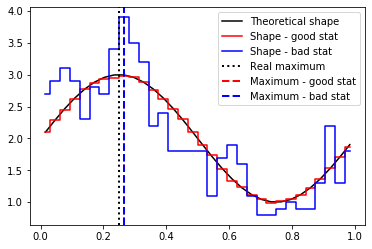

In [9]:
phase_bin = 1 / 32.
ph = np.arange(phase_bin / 2, phase_bin / 2 + 1, phase_bin)
shape = np.sin(2 * np.pi * ph) + 2
pr_1 = np.random.poisson(shape * 10000) / 10000
pr_2 = np.random.poisson(shape * 10) / 10

# PLOTTING -----------------------------
plt.plot(ph, shape, label='Theoretical shape', color='k')
plt.plot(
    ph, pr_1, drawstyle='steps-mid', color='r',
    label='Shape - good stat')
plt.plot(
    ph, pr_2, drawstyle='steps-mid', color='b',
    label='Shape - bad stat')
plt.axvline(0.25, ls=':', color='k', lw=2, label='Real maximum')
plt.axvline(
    ph[np.argmax(pr_1)], ls='--', color='r', lw=2,
    label='Maximum - good stat')
plt.axvline(
    ph[np.argmax(pr_2)], ls='--', color='b', lw=2,
    label='Maximum - bad stat')

_ = plt.legend()
# --------------------------------------

## TOA from single sinusoidal fit

**Advantage**

* Relatively easy task (fitting with a sinusoid)

* Errors are well determined provided that the pulse is broad

**Disadvantages**

* If profile is not sinusoidal, might not be well determined

Below, the phase of the pulse is always 0.25

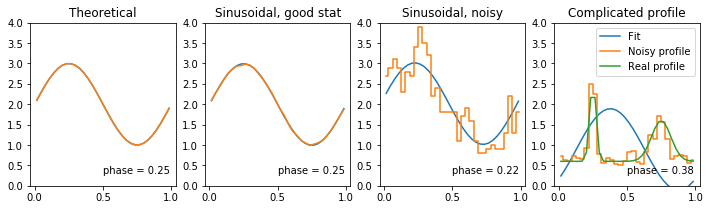

In [10]:
def sinusoid(phase, phase0, amplitude, offset):
    return offset + np.cos(2 * np.pi * (phase - phase0))

from scipy.optimize import curve_fit

# PLOTTING ------------------
fig = plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0])
ax1.set_title('Theoretical')
ax2 = plt.subplot(gs[1])
ax2.set_title('Sinusoidal, good stat')
ax3 = plt.subplot(gs[2])
ax3.set_title('Sinusoidal, noisy')
ax4 = plt.subplot(gs[3])
ax4.set_title('Complicated profile')
# ---------------------------

# Fit sinusoid to theoretical shape
par, pcov = curve_fit(sinusoid, ph, shape)

# PLOTTING -----------------------------------------------
ax1.plot(ph, sinusoid(ph, *par))
ax1.plot(ph, shape)
par[0] -= np.floor(par[0])
ax1.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax1.set_ylim([0, 4])

# Fit to good-stat line
# ---------------------------------------------------------

par, pcov = curve_fit(sinusoid, ph, pr_1)

# PLOTTING -----------------------------------------------

ax2.plot(ph, sinusoid(ph, *par))
ax2.plot(ph, pr_1)
par[0] -= np.floor(par[0])
ax2.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax2.set_ylim([0, 4])

# Fit to bad-stat line
# ---------------------------------------------------------

par, pcov = curve_fit(sinusoid, ph, pr_2)

# PLOTTING -----------------------------------------------

ax3.plot(ph, sinusoid(ph, *par))
ax3.plot(ph, pr_2, drawstyle='steps-mid')
par[0] -= np.floor(par[0])
ax3.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax3.set_ylim([0, 4])

# Now try with a complicated profile (a double Gaussian)
# ---------------------------------------------------------

pr_3_clean = 0.3 + np.exp(- (ph - 0.25) ** 2 / 0.001) + 0.5 * np.exp(- (ph - 0.75) ** 2 / 0.01)
pr_3 = np.random.poisson(pr_3_clean * 100) / 50
# Let us normalize the template with the same factor (100 / 50) of the randomized one. It will be helpful later
pr_3_clean *= 2

par, pcov = curve_fit(sinusoid, ph, pr_3, maxfev=10000)

# PLOTTING -----------------------------------------------

ax4.plot(ph, sinusoid(ph, *par), label='Fit')
ax4.plot(ph, pr_3, drawstyle='steps-mid', label='Noisy profile')
ax4.plot(ph, pr_3_clean, label='Real profile')

par[0] -= np.floor(par[0])
ax4.annotate('phase = {:.2f}'.format(par[0]), xy=(.5, .3))
ax4.set_ylim([0, 4])
_ = ax4.legend()
# ---------------------------------------------------------

## TOA from non-sinusoidal fit: multiple harmonic fitting

**Multiple harmonic fitting**$^1$ (the profile is described by a sum of sinusoids) is just an extension of the single-harmonic fit by adding additional sinusoidal components at multiple frequencies.

**Advantages**

* Still conceptually easy, but more robust and reliable

**Disadvantages**

* The phase is not determined by the fit (in general, it isn't he phase of any of the sinusoids [Exercise: why?]) and needs to be determined from the maximum of the profile. Errors are not straightforward to implement.

$^1$e.g. Riggio, A. et al. Timing of the accreting millisecond pulsar IGR J17511-3057. _A&A_ **526**, 95 (2011).


## TOA from non-sinusoidal fit: Template pulse shapes

* **Cross-correlation** of template pulse shape

* **Fourier-domain fitting (FFTFIT)**$^1$ -> the usual choice. Consists of taking the Fourier transform of the profile $\mathcal{P}$ and of the template $\mathcal{T}$ and minimizing the following objective function (similar to $\chi^2$):
\begin{equation}
F = \sum_k \frac{|\mathcal{P}_k - a\mathcal{T}_k e^{-2\pi i k\phi}|^2}{\sigma^2}
\end{equation}

**Advantages**

* Much more robust and reliable

* Errors well determined whatever the pulse shape

**Disadvantages**

* Relatively trickier to implement

* Needs good template pulse profile

$^1$Taylor, J. H. Pulsar Timing and Relativistic Gravity. _Philosophical Transactions: Physical Sciences and Engineering_ **341**, 117â€“134 (1992).

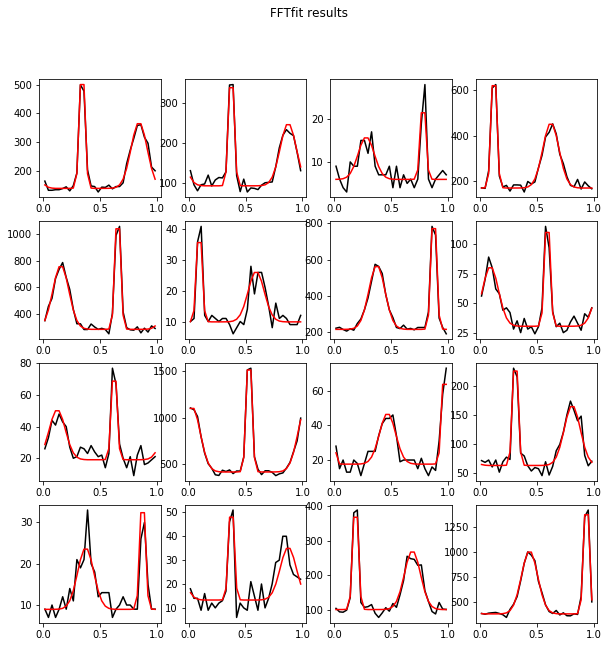

In [11]:
def fftfit_fun(profile, template, amplitude, phase):
    '''Objective function to be minimized - \'a la Taylor (1992).'''
    
    prof_ft = np.fft.fft(profile)
    temp_ft = np.fft.fft(template)
    freq = np.fft.fftfreq(len(profile))
    good = freq > 0
    idx = np.arange(0, prof_ft.size, dtype=int)
    sigma = np.std(prof_ft[good])
    return np.sum(np.absolute(prof_ft - temp_ft*amplitude*np.exp(-2*np.pi*1.0j*idx*phase))**2 / sigma)

def obj_fun(pars, data):
    '''Wrap parameters and input data up in order to be used with minimization
    algorithms.'''
    amplitude, phase = pars
    profile, template = data
    return fftfit_fun(profile, template, amplitude, phase)

# Produce 16 realizations of pr_3, at different amplitudes and phases, and reconstruct the phase
from scipy.optimize import fmin, basinhopping

# PLOTTING --------------------------

fig = plt.figure(figsize=(10, 10))
fig.suptitle('FFTfit results')
gs = gridspec.GridSpec(4, 4)

# -----------------------------------
amp0 = 1
phase0 = 0
p0 = [amp0, phase0]
for i in range(16):
    # PLOTTING --------------------------
    col = i % 4
    row = i // 4
    # -----------------------------------

    factor = 10 ** np.random.uniform(1, 3)
    pr_orig = np.random.poisson(pr_3_clean * factor)
    roll_len = np.random.randint(0, len(pr_orig) - 1)
    pr = np.roll(pr_orig, roll_len)

#    # Using generic minimization algorithms is faster, but local minima can be a problem
#    res = fmin(obj_fun, p0, args=([pr, pr_3_clean],), disp=False, full_output=True)
#    amplitude_res, phase_res = res[0]

    # The basinhopping algorithm is very slow but very effective in finding 
    # the global minimum of functions with local minima.
    res = basinhopping(obj_fun, p0, minimizer_kwargs={'args':([pr, pr_3_clean],)})
    amplitude_res, phase_res = res.x
    
    phase_res -= np.floor(phase_res)
    newphase = ph + phase_res
    newphase -= np.floor(newphase)
    
    # Sort arguments of phase so that they are ordered in plot
    # (avoids ugly lines traversing the plot)
    order = np.argsort(newphase)

    # PLOTTING --------------------------

    ax = plt.subplot(gs[row, col])
    ax.plot(ph, pr, 'k-')
    
    ax.plot(newphase[order], amplitude_res * pr_3_clean[order], 'r-')
    # -------------------------------------

## The Z_n search

$Z_n^2$ is another widely used statistics for high-energy pulsar searches.
It measures how the probability of photons in a given phase is proportional to a given combination of $n$ harmonics. Or in other words, how well the pulse profile is described by a combination of sinusoidal harmonics.
The definition of this statistical indicator is (Buccheri+1983):

$$
Z^2_n = \dfrac{2}{N} \sum_{k=1}^n \left[{\left(\sum_{j=1}^N \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^N \sin k \phi_j\right)}^2\right] \; ,
$$

The formula can be slightly modified for binned data, by introducing a `weight` quantity giving the number of photons (or another measure of flux) in a given bin (Huppenkothen+2019):

$$
Z^2_n \approx \dfrac{2}{\sum_j{w_j}} \sum_{k=1}^n \left[{\left(\sum_{j=1}^m w_j \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^m w_j \sin k \phi_j\right)}^2\right]
$$

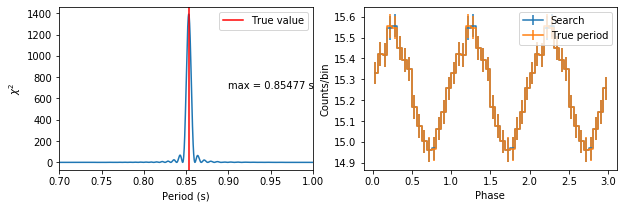

In [12]:
def z_n(time, p, n=2, weight=1):
    '''Z^2_n statistics, a` la Buccheri+03, A&A, 128, 245, eq. 2.

    Parameters
    ----------
    phase : array of floats
        The phases of the events
    n : int, default 2
        Number of harmonics, including the fundamental

    Other Parameters
    ----------------
    norm : float or array of floats
        A normalization factor that gets multiplied as a weight.

    Returns
    -------
    z2_n : float
        The Z^2_n statistics of the events.
    '''
    phase = time / p
    
    nbin = len(phase)

    if nbin == 0:
        return 0

    weight = np.asarray(weight)
    if weight.size == 1:
        total_weight = nbin * weight
    else:
        total_weight = np.sum(weight)
    phase = phase * 2 * np.pi
    return 2 / total_weight * \
        np.sum([np.sum(np.cos(k * phase) * weight) ** 2 +
                np.sum(np.sin(k * phase) * weight) ** 2
                for k in range(1, n + 1)])

trial_periods = np.arange(0.7, 1.0, 0.0002)
stats = np.zeros_like(trial_periods)
for i, p in enumerate(trial_periods):
    stats[i] = z_n(time, p, weight=signal)

bestp = trial_periods[np.argmax(stats)]

phase_search, profile_search, profile_search_err = \
    epoch_folding(time, total, bestp)
phase, profile, profile_err = epoch_folding(time, total, period)

# PLOTTING -------------------------------
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.plot(trial_periods, stats)
ax.set_xlim([0.7, 1])
ax.set_xlabel('Period (s)')
ax.set_ylabel('$\chi^2$')
ax.axvline(period, color='r', label="True value")
_ = ax.legend()
ax.annotate('max = {:.5f} s'.format(pmax), xy=(.9, max(stats) / 2))

ax2 = plt.subplot(gs[1])

ax2.errorbar(phase_search, profile_search, yerr=profile_search_err,
             drawstyle='steps-mid', label='Search')
ax2.errorbar(phase, profile, yerr=profile_err, drawstyle='steps-mid',
             label='True period')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Counts/bin')

_ = ax2.legend()
# ------------------------------------------